## Generate the dataset

We generate a simple dataset with some gaussian distributions around a few points in the $\mathbb{R}^2$ space. 

We will have 2 classes to predict, represented by the <span style="color:blue">blue</span> $(y = -1)$ and <span style="color:red">red</span> $(y = 1)$ colors.

- $\mathbf{x} \in \mathbb{R}^2$
- $y \in \{-1, 1\}$

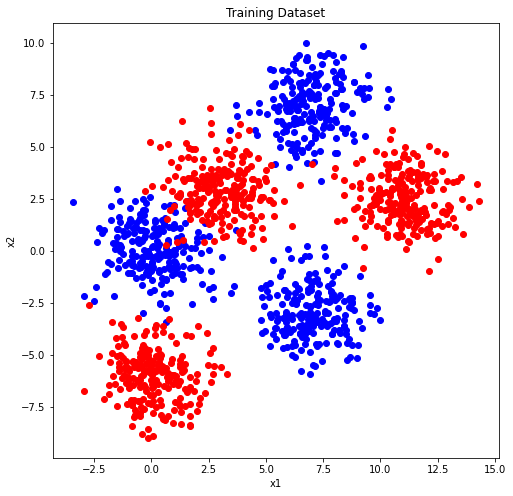

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle

# Seed for reproducibility
SEED = 1

def gen_data(seed):
    X1, y1 = datasets.make_gaussian_quantiles(cov=1.5,
                                 n_samples=250, n_features=2,
                                 n_classes=1, random_state=seed)
    X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=250, n_features=2,
                                 n_classes=1, random_state=seed+1)
    X3, y3 = datasets.make_gaussian_quantiles(mean=(7, 7), cov=1.5,
                                 n_samples=250, n_features=2,
                                 n_classes=1, random_state=seed+2)
    X4, y4 = datasets.make_gaussian_quantiles(mean=(0, -6), cov=1.5,
                                 n_samples=250, n_features=2,
                                 n_classes=1, random_state=seed+3)
    X5, y5 = datasets.make_gaussian_quantiles(mean=(7, -3), cov=1.5,
                                 n_samples=250, n_features=2,
                                 n_classes=1, random_state=seed+4)
    X6, y6 = datasets.make_gaussian_quantiles(mean=(11, 2.5), cov=1.5,
                                 n_samples=250, n_features=2,
                                 n_classes=1, random_state=seed+5)    
    X = np.concatenate((X1, X2, X3, X4, X5, X6))
    y = np.concatenate((y1, - y2 + 1, y3, -y4 + 1, y5, -y6 + 1))
    y = 2*y-1
    X, y = shuffle(X, y, random_state=seed)
    return X, y

X,y = gen_data(SEED)
Xtest,X = np.split(X,[200])
ytest,y = np.split(y,[200])

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure(figsize=(8,8))
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Training Dataset')
plt.show()

## Hyper-parameters

### Fitness function

We need to choose a fitness function $f$ to maximize :

$$
\begin{equation}
f(\hat{y}, y) = 4 - \text{MSE}(\hat{y}, y) = 4 - \frac{1}{N}\sum_{i=1}^{N}(\hat{y} - y)^2 \quad \in \quad [0, 4]
\end{equation}
$$

The Neural Networks with the higher fitness function will be considered as the best candidates during the selection process.

### Configuration file (NEAT)

We will test the NEAT algorithm with the official neat library (https://neat-python.readthedocs.io/en/latest/).

First we need to configurate the hyperparameters of the algorithm in a configuration file.

Here are some of the most critical parameters :


#### Network parameters

```python
# network parameters
num_hidden              = 0
num_inputs              = 2
num_outputs             = 1
```

#### Bias and weight initialization

- We **initialize the bias and weights** according to a standard normal distribution $(\mu = 0, \sigma = 1)$.

- We set the **mutate rate** (probability to mutate), and **mutate power** (standard deviation of the mutation) for the bias and weights. 

- We set the **add/remove rates** for the nodes and connections (probability for a node or for an edge to be added/removed)


```python
# node bias options
bias_init_mean          = 0.0  # Standard normal distribution (mu = 0, sigma = 1)
bias_init_stdev         = 1.0
bias_mutate_power       = 0.5  # Standard deviation of the mutation
bias_mutate_rate        = 0.7  # 70% of chance to mutate

# connection weight options
weight_init_mean        = 0.0  # Standard normal distribution (mu = 0, sigma = 1)
weight_init_stdev       = 1.0
weight_mutate_power     = 0.5  # Standard deviation of the mutation
weight_mutate_rate      = 0.8  # 80% of chance to mutate

# node add/remove rates
node_add_prob           = 0.3
node_delete_prob        = 0.3

# connection add/remove rates
conn_add_prob           = 0.5  
conn_delete_prob        = 0.5
````

#### Speciation

```python
[DefaultSpeciesSet]
compatibility_threshold = 3.0

[DefaultStagnation]
species_fitness_func    = max
max_stagnation          = 20
species_elitism         = 2

[DefaultReproduction]
elitism                 = 2
survival_threshold      = 0.2

```

## NEAT Algorithm

In [2]:
from __future__ import print_function
import os
import neat
import visualize
from sklearn.preprocessing import StandardScaler
from IPython.display import display

scaler = StandardScaler()
X_s = scaler.fit_transform(X)
Xtest_s = scaler.transform(Xtest)

n_train = X.shape[0]

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 4.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(X_s, y):
            output = net.activate((xi[0], xi[1]))
            genome.fitness -= (1 / n_train) * (output[0] - xo) ** 2


def run(config_file, n_gen):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5, filename_prefix='./checkpoints/neat-checkpoint-'))

    # Run for up to n_gen generations.
    winner = p.run(eval_genomes, n_gen)

    return winner, config, stats


## Training on 150 generations

In [ ]:
import random

random.seed(SEED)

local_dir = os.path.dirname('')

# Config file path
config_path = os.path.join(local_dir, 'config-feedforward-gaussian')

# Run the training
winner, config, stats = run(config_path, n_gen = 300)
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)


 ****** Running generation 0 ****** 

Population's average fitness: 2.21061 stdev: 0.27505
Best fitness: 2.88668 - size: (1, 2) - species 1 - id 247
Average adjusted fitness: 0.474
Mean genetic distance 1.371, standard deviation 0.485
Population of 300 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   300      2.9    0.474     0
Total extinctions: 0
Generation time: 2.893 sec

 ****** Running generation 1 ****** 

Population's average fitness: 2.34373 stdev: 0.31034
Best fitness: 3.00000 - size: (1, 0) - species 1 - id 306
Average adjusted fitness: 0.548
Mean genetic distance 1.552, standard deviation 0.460
Population of 300 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   300      3.0    0.548     0
Total extinctions: 0
Generation time: 2.806 sec (2.849 average)

 ****** Running generation 2 ****** 

Population's average fitness: 2.61253 stdev: 

Population's average fitness: 2.89242 stdev: 0.30086
Best fitness: 3.24052 - size: (2, 4) - species 1 - id 748
Average adjusted fitness: 0.702
Mean genetic distance 2.363, standard deviation 0.891
Population of 299 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   14   193      3.2    0.784    12
     2   12    21      3.0    0.355    11
     3   12    14      3.0    0.835    11
     4   11    34      3.0    0.652    10
     5    3    21      3.0    0.835     2
     6    2    16      3.0    0.751     1
Total extinctions: 0
Generation time: 1.849 sec (1.997 average)
Saving checkpoint to ./checkpoints/neat-checkpoint-14

 ****** Running generation 15 ****** 

Population's average fitness: 2.87204 stdev: 0.33562
Best fitness: 3.24052 - size: (2, 4) - species 1 - id 748
Average adjusted fitness: 0.760
Mean genetic distance 2.391, standard deviation 0.845
Population of 299 members in 6 species:
   ID   age  size  fitness  adj 

Population's average fitness: 2.88957 stdev: 0.31445
Best fitness: 3.24052 - size: (2, 4) - species 1 - id 748
Average adjusted fitness: 0.804
Mean genetic distance 2.085, standard deviation 0.732
Population of 299 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   27   142      3.2    0.784    25
     2   25    66      3.0    0.778     2
     5   16    45      3.0    0.801    15
     6   15    46      3.0    0.851    14
Total extinctions: 0
Generation time: 1.996 sec (2.016 average)

 ****** Running generation 28 ****** 

Population's average fitness: 2.89938 stdev: 0.30154
Best fitness: 3.24052 - size: (2, 4) - species 1 - id 748
Average adjusted fitness: 0.816
Mean genetic distance 2.145, standard deviation 0.681
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   28   139      3.2    0.801    26
     2   26    63      3.0    0.798     3
  

Population's average fitness: 2.86863 stdev: 0.32349
Best fitness: 3.24052 - size: (2, 4) - species 1 - id 748
Average adjusted fitness: 0.776
Mean genetic distance 2.479, standard deviation 0.865
Population of 302 members in 11 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   40    96      3.2    0.753    38
     2   38    30      3.0    0.704    15
     7   11    21      3.0    0.791    10
     8    3    48      3.0    0.765     2
     9    3    22      3.0    0.837     2
    10    2    34      3.0    0.685     1
    11    1    11      3.0    0.837     0
    12    1    11      3.0    0.837     0
    13    0    20       --       --     0
    14    0     8       --       --     0
    15    0     1       --       --     0
Total extinctions: 0
Generation time: 2.058 sec (2.053 average)

 ****** Running generation 41 ****** 

Population's average fitness: 2.86482 stdev: 0.33376
Best fitness: 3.24052 - size: (2, 4) - species 1 - id 748
A

Population's average fitness: 2.85151 stdev: 0.33299
Best fitness: 3.24052 - size: (2, 4) - species 1 - id 748

Species 7 with 21 members is stagnated: removing it
Average adjusted fitness: 0.809
Mean genetic distance 2.490, standard deviation 0.799
Population of 300 members in 9 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   50   110      3.2    0.749    48
     8   13    19      3.0    0.780    12
     9   13    10      3.0    0.797    12
    10   12    14      3.0    0.865    11
    11   11    21      3.0    0.837    10
    12   11    19      3.0    0.865    10
    13   10    76      3.0    0.765     9
    14   10    18      3.0    0.833     9
    15   10    13      3.0    0.788     9
Total extinctions: 0
Generation time: 2.056 sec (2.101 average)

 ****** Running generation 51 ****** 

Population's average fitness: 2.89862 stdev: 0.30371
Best fitness: 3.24052 - size: (2, 4) - species 1 - id 748
Average adjusted fitness: 0.826
M

Population's average fitness: 2.84931 stdev: 0.35037
Best fitness: 3.24052 - size: (2, 4) - species 1 - id 748

Species 13 with 69 members is stagnated: removing it

Species 14 with 10 members is stagnated: removing it

Species 15 with 18 members is stagnated: removing it
Average adjusted fitness: 0.791
Mean genetic distance 2.239, standard deviation 1.348
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   61   159      3.2    0.759    59
    16    2   141      3.0    0.823     1
Total extinctions: 0
Generation time: 2.030 sec (2.034 average)

 ****** Running generation 62 ****** 

Population's average fitness: 2.80423 stdev: 0.37057
Best fitness: 3.24052 - size: (2, 4) - species 1 - id 748
Average adjusted fitness: 0.737
Mean genetic distance 2.245, standard deviation 1.309
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  

Population's average fitness: 2.79818 stdev: 0.39446
Best fitness: 3.41503 - size: (5, 7) - species 1 - id 21392
Average adjusted fitness: 0.600
Mean genetic distance 2.364, standard deviation 1.233
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   76   143      3.4    0.703     3
    16   17    81      3.0    0.735    16
    17    7    76      3.0    0.364     6
Total extinctions: 0
Generation time: 2.166 sec (2.251 average)

 ****** Running generation 77 ****** 

Population's average fitness: 2.76868 stdev: 0.42215
Best fitness: 3.41503 - size: (5, 7) - species 1 - id 21392
Average adjusted fitness: 0.667
Mean genetic distance 2.471, standard deviation 1.282
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   77   148      3.4    0.682     4
    16   18    82      3.0    0.753    17
    17    8    71      3.0    0.567     

Population's average fitness: 2.81138 stdev: 0.38566
Best fitness: 3.41503 - size: (5, 7) - species 1 - id 21392
Average adjusted fitness: 0.691
Mean genetic distance 2.011, standard deviation 0.805
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   91   174      3.4    0.678    18
    18   13   122      3.0    0.704    12
    19    0     4       --       --     0
Total extinctions: 0
Generation time: 2.394 sec (2.170 average)

 ****** Running generation 92 ****** 

Population's average fitness: 2.87979 stdev: 0.32983
Best fitness: 3.41503 - size: (5, 7) - species 1 - id 21392
Average adjusted fitness: 0.692
Mean genetic distance 2.144, standard deviation 0.646
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   92   140      3.4    0.735    19
    18   14   114      3.0    0.690    13
    19    1    46      3.0    0.650     

Population's average fitness: 2.88734 stdev: 0.32053
Best fitness: 3.41503 - size: (5, 7) - species 1 - id 21392
Average adjusted fitness: 0.741
Mean genetic distance 2.511, standard deviation 0.802
Population of 299 members in 9 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  104    72      3.4    0.726    31
    19   13    12      3.0    0.760    12
    20   11    29      3.0    0.757    10
    21    5    21      3.0    0.749     4
    22    5    22      3.0    0.785     4
    23    4    23      3.0    0.706     3
    24    4    20      3.0    0.727     3
    25    4    17      3.0    0.785     3
    26    4    83      3.0    0.669     3
Total extinctions: 0
Generation time: 2.027 sec (2.135 average)
Saving checkpoint to ./checkpoints/neat-checkpoint-104

 ****** Running generation 105 ****** 

Population's average fitness: 2.86660 stdev: 0.34260
Best fitness: 3.41503 - size: (5, 7) - species 1 - id 21392
Average adjusted fitness: 

Population's average fitness: 2.87533 stdev: 0.32620
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282

Species 20 with 17 members is stagnated: removing it
Average adjusted fitness: 0.653
Mean genetic distance 2.566, standard deviation 0.880
Population of 302 members in 10 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  114    79      3.6    0.660     7
    21   15    13      3.0    0.616    14
    22   15    19      3.0    0.688    14
    23   14    19      3.0    0.671    13
    24   14    22      3.0    0.669    13
    25   14    20      3.0    0.680    13
    26   14    80      3.0    0.602    13
    27    8    25      3.0    0.605     7
    28    7    15      3.0    0.691     6
    29    0    10       --       --     0
Total extinctions: 0
Generation time: 2.186 sec (2.108 average)
Saving checkpoint to ./checkpoints/neat-checkpoint-114

 ****** Running generation 115 ****** 

Population's average fitness: 2.88702 stde

Population's average fitness: 2.85573 stdev: 0.35612
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282
Average adjusted fitness: 0.696
Mean genetic distance 2.712, standard deviation 0.886
Population of 299 members in 20 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  122    64      3.6    0.610    15
    27   16    13      3.0    0.666    15
    28   15    12      3.0    0.708    14
    29    8    17      3.0    0.720     7
    30    6    23      3.0    0.654     5
    31    6    15      3.0    0.647     5
    32    6     9      3.0    0.708     5
    33    6    13      3.0    0.693     5
    34    3    11      3.0    0.739     2
    35    3    18      3.0    0.684     2
    36    3    13      3.0    0.739     2
    37    3    11      3.0    0.601     2
    38    3    13      3.0    0.662     2
    39    3     9      3.0    0.739     2
    40    2     9      3.0    0.739     1
    41    1    15      3.0    0.739     0
    

Population's average fitness: 2.88309 stdev: 0.31495
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282

Species 28 with 8 members is stagnated: removing it
Average adjusted fitness: 0.628
Mean genetic distance 2.718, standard deviation 0.854
Population of 297 members in 25 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  128    53      3.6    0.546    21
    29   14    14      3.0    0.667    13
    30   12     4      3.0    0.667    11
    31   12     7      3.0    0.667    11
    32   12     6      3.0    0.667    11
    33   12     9      3.0    0.667    11
    34    9     9      3.0    0.594     8
    35    9    11      3.0    0.628     8
    36    9     6      3.0    0.667     8
    37    9    12      3.0    0.609     8
    38    9     8      3.0    0.667     8
    39    9    10      3.0    0.594     8
    40    8    12      3.0    0.609     7
    41    7     6      3.0    0.550     6
    42    7     6      3.0    0.667

Population's average fitness: 2.88136 stdev: 0.32731
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282
Average adjusted fitness: 0.697
Mean genetic distance 2.732, standard deviation 0.793
Population of 299 members in 28 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  134    57      3.6    0.643    27
    29   20    15      3.0    0.738    19
    30   18     6      3.0    0.738    17
    31   18     7      3.0    0.738    17
    32   18     9      3.0    0.653    17
    33   18     5      3.0    0.645    17
    34   15     6      3.0    0.738    14
    35   15    12      3.0    0.622    14
    36   15     8      3.0    0.686    14
    37   15     7      3.0    0.738    14
    38   15     9      3.0    0.705    14
    39   15    12      3.0    0.660    14
    40   14     4      3.0    0.738    13
    41   13     8      3.0    0.738    12
    42   13     6      3.0    0.660    12
    43   13     9      3.0    0.686    12
    

Population's average fitness: 2.90912 stdev: 0.28269
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282

Species 34 with 10 members is stagnated: removing it

Species 35 with 7 members is stagnated: removing it

Species 36 with 3 members is stagnated: removing it

Species 37 with 5 members is stagnated: removing it

Species 38 with 4 members is stagnated: removing it

Species 39 with 7 members is stagnated: removing it
Average adjusted fitness: 0.684
Mean genetic distance 2.679, standard deviation 0.843
Population of 301 members in 17 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  140    67      3.6    0.620    33
    40   20     6      3.0    0.696    19
    41   19     7      3.0    0.696    18
    42   19     9      3.0    0.696    18
    43   19     5      3.0    0.696    18
    44   18    10      3.0    0.696    17
    45   18     6      3.0    0.696    17
    46   17     5      3.0    0.696    16
    47   17   128    

Population's average fitness: 2.89898 stdev: 0.30145
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282

Species 52 with 25 members is stagnated: removing it
Average adjusted fitness: 0.611
Mean genetic distance 2.731, standard deviation 0.794
Population of 300 members in 15 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  148    99      3.6    0.617    41
    53   19    18      3.0    0.643    18
    54   18    30      3.0    0.545    17
    55   15    27      3.0    0.633    14
    56    3    17      3.0    0.618     2
    57    3    29      3.0    0.627     2
    58    3    15      3.0    0.601     2
    59    3    16      3.0    0.625     2
    60    2    19      3.0    0.529     1
    61    1    13      3.0    0.673     0
    62    0     8       --       --     0
    63    0     2       --       --     0
    64    0     5       --       --     0
    65    0     1       --       --     0
    66    0     1       --       -

Population's average fitness: 2.87969 stdev: 0.32509
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282
Average adjusted fitness: 0.655
Mean genetic distance 2.598, standard deviation 0.793
Population of 300 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  156    76      3.6    0.656    49
    56   11    23      3.0    0.676    10
    57   11    13      3.0    0.663    10
    58   11    12      3.0    0.666    10
    59   11    14      3.0    0.656    10
    60   10    13      3.0    0.703     9
    61    9    12      3.0    0.659     8
    62    8    69      3.0    0.532     7
    63    8    14      3.0    0.666     7
    64    8    16      3.0    0.633     7
    65    8    14      3.0    0.703     7
    66    8    18      3.0    0.661     7
    67    2     6      3.0    0.638     1
Total extinctions: 0
Generation time: 2.147 sec (2.086 average)

 ****** Running generation 157 ****** 

Population's average fitn

Population's average fitness: 2.89503 stdev: 0.29883
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282
Average adjusted fitness: 0.658
Mean genetic distance 2.652, standard deviation 0.828
Population of 299 members in 17 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  164    62      3.6    0.581    57
    56   19    13      3.0    0.695    18
    57   19    11      3.0    0.580    18
    58   19     8      3.0    0.695    18
    59   19    11      3.0    0.695    18
    60   18     9      3.0    0.641    17
    61   17    11      3.0    0.668    16
    62   16    65      3.0    0.603    15
    63   16     5      3.0    0.695    15
    64   16    12      3.0    0.646    15
    65   16     9      3.0    0.695    15
    66   16    16      3.0    0.667    15
    67   10    10      3.0    0.695     9
    68    4    14      3.0    0.695     3
    69    3    14      3.0    0.695     2
    70    3    15      3.0    0.542     2
    

Population's average fitness: 2.89607 stdev: 0.30225
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282
Average adjusted fitness: 0.588
Mean genetic distance 2.683, standard deviation 0.907
Population of 302 members in 23 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  172    58      3.6    0.586    65
    67   18     9      3.0    0.626    17
    68   12    14      3.0    0.579    11
    69   11    11      3.0    0.613    10
    70   11    20      3.0    0.619    10
    71   10    17      3.0    0.659     9
    72    7     9      3.0    0.659     6
    73    3    14      3.0    0.659     2
    74    3     6      3.0    0.509     2
    75    3     5      3.0    0.559     2
    76    3    11      3.0    0.459     2
    77    3     6      3.0    0.539     2
    78    2    16      3.0    0.616     1
    79    2    29      3.0    0.599     1
    80    2    11      3.0    0.659     1
    81    2     9      3.0    0.559     1
    

Population's average fitness: 2.91118 stdev: 0.28069
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282
Average adjusted fitness: 0.677
Mean genetic distance 2.699, standard deviation 0.904
Population of 301 members in 28 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  178    57      3.6    0.635    71
    68   18     4      3.0    0.703    17
    69   17     7      3.0    0.703    16
    70   17    11      3.0    0.703    16
    71   16     6      3.0    0.703    15
    72   13     5      3.0    0.703    12
    73    9     6      3.0    0.703     8
    74    9     7      3.0    0.703     8
    75    9     6      3.0    0.703     8
    76    9    11      3.0    0.703     8
    77    9     8      3.0    0.615     8
    78    8     8      3.0    0.703     7
    79    8    13      3.0    0.703     7
    80    8     7      3.0    0.645     7
    81    8     8      3.0    0.703     7
    82    8     5      3.0    0.703     7
    

Population's average fitness: 2.91426 stdev: 0.28114
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282

Species 71 with 10 members is stagnated: removing it
Average adjusted fitness: 0.709
Mean genetic distance 2.730, standard deviation 0.917
Population of 298 members in 36 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  183    53      3.6    0.657    76
    72   18     5      3.0    0.735    17
    73   14    10      3.0    0.735    13
    74   14    10      3.0    0.735    13
    75   14     7      3.0    0.683    13
    76   14     6      3.0    0.657    13
    77   14     7      3.0    0.735    13
    78   13    10      3.0    0.735    12
    79   13    11      3.0    0.657    12
    80   13     9      3.0    0.735    12
    81   13    11      3.0    0.631    12
    82   13     9      3.0    0.735    12
    83   13     9      3.0    0.735    12
    84   12    10      3.0    0.692    11
    85   12     8      3.0    0.73

Population's average fitness: 2.91509 stdev: 0.28070
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282
Average adjusted fitness: 0.708
Mean genetic distance 2.708, standard deviation 0.834
Population of 306 members in 43 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  188    48      3.6    0.654    81
    73   19    10      3.0    0.739    18
    74   19     4      3.0    0.739    18
    75   19     5      3.0    0.739    18
    76   19     5      3.0    0.739    18
    77   19     3      3.0    0.682    18
    78   18     6      3.0    0.739    17
    79   18     2      3.0    0.624    17
    80   18     6      3.0    0.739    17
    81   18     4      3.0    0.647    17
    82   18     9      3.0    0.739    17
    83   18     3      3.0    0.739    17
    84   17     6      3.0    0.739    16
    85   17     6      3.0    0.739    16
    86   17     3      3.0    0.739    16
    87   16     6      3.0    0.739    15
    

Population's average fitness: 2.92080 stdev: 0.26981
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282

Species 84 with 8 members is stagnated: removing it

Species 85 with 11 members is stagnated: removing it

Species 86 with 4 members is stagnated: removing it
Average adjusted fitness: 0.704
Mean genetic distance 2.775, standard deviation 0.882
Population of 291 members in 33 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  192    53      3.6    0.673    85
    87   20     7      3.0    0.731    19
    88   20     3      3.0    0.731    19
    89   19     6      3.0    0.731    18
    90   19     6      3.0    0.731    18
    91   18     7      3.0    0.731    17
    92   18     3      3.0    0.731    17
    93   18    51      3.0    0.643    17
    94   14     7      3.0    0.731    13
    95   11     9      3.0    0.731    10
    96   11     7      3.0    0.664    10
    97   11     6      3.0    0.637    10
    98    9 

Population's average fitness: 2.90783 stdev: 0.28868
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282
Average adjusted fitness: 0.657
Mean genetic distance 2.765, standard deviation 0.833
Population of 302 members in 36 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  197    52      3.6    0.655    90
    94   19     7      3.0    0.555    18
    95   16     9      3.0    0.704    15
    96   16     8      3.0    0.630    15
    97   16     9      3.0    0.652    15
    98   14     6      3.0    0.652    13
    99   14    11      3.0    0.617    13
   100   14     8      3.0    0.646    13
   101   14    13      3.0    0.704    13
   102   14    10      3.0    0.704    13
   103   14     8      3.0    0.646    13
   104   14     9      3.0    0.661    13
   105   14     4      3.0    0.704    13
   106   14     8      3.0    0.704    13
   107   11     9      3.0    0.704    10
   108   11     3      3.0    0.704    10
   1

Population's average fitness: 2.89618 stdev: 0.30547
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282
Average adjusted fitness: 0.636
Mean genetic distance 2.809, standard deviation 0.867
Population of 300 members in 39 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  201    43      3.6    0.561    94
    95   20     4      3.0    0.532    19
    96   20     2      3.0    0.675    19
    97   20     4      3.0    0.675    19
    98   18     5      3.0    0.675    17
    99   18     4      3.0    0.675    17
   100   18     3      3.0    0.675    17
   101   18     6      3.0    0.675    17
   102   18     3      3.0    0.675    17
   103   18     5      3.0    0.579    17
   104   18     2      3.0    0.484    17
   105   18     4      3.0    0.675    17
   106   18     4      3.0    0.675    17
   107   15     5      3.0    0.579    14
   108   15     2      3.0    0.675    14
   109   14     3      3.0    0.675    13
   1

Population's average fitness: 2.90436 stdev: 0.29190
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282
Average adjusted fitness: 0.639
Mean genetic distance 2.810, standard deviation 0.904
Population of 302 members in 27 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  205    53      3.6    0.595    98
   107   19     5      3.0    0.673    18
   108   19     6      3.0    0.673    18
   109   18     6      3.0    0.673    17
   110   18     3      3.0    0.673    17
   111   18     6      3.0    0.557    17
   112   18     3      3.0    0.480    17
   113   18     7      3.0    0.673    17
   114   17     7      3.0    0.590    16
   115   16    11      3.0    0.673    15
   116   15     2      3.0    0.673    14
   117   15     5      3.0    0.557    14
   118   14     6      3.0    0.673    13
   119   11     4      3.0    0.673    10
   120   11     7      3.0    0.673    10
   121   11     5      3.0    0.673    10
   1

Population's average fitness: 2.90581 stdev: 0.29288
Best fitness: 3.55155 - size: (5, 8) - species 1 - id 31282

Species 116 with 8 members is stagnated: removing it

Species 117 with 3 members is stagnated: removing it
Average adjusted fitness: 0.688
Mean genetic distance 2.769, standard deviation 0.940
Population of 294 members in 16 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  211    64      3.6    0.647   104
   118   20     9      3.0    0.725    19
   119   17     7      3.0    0.725    16
   120   17     9      3.0    0.725    16
   121   17     9      3.0    0.725    16
   122   16     5      3.0    0.725    15
   123   16    10      3.0    0.725    15
   124   16     7      3.0    0.725    15
   125   15     7      3.0    0.586    14
   126   15     8      3.0    0.725    14
   127   15   122      3.0    0.679    12
   128   14     6      3.0    0.644    13
   129   13     7      3.0    0.725    12
   130   13     7     

## Results

### Stats and winning network graph

In [ ]:
def plot_results (winner, config, stats):
    node_names = {-1:'X1', -2: 'X2', 0:'OUTPUT'}
    
    # Plot stats and speciation
    visualize.plot_stats(stats, ylog=False, view=True, filename='./visualization/avg_fitness.svg')
    visualize.plot_species(stats, view=True, filename='./visualization/speciation.svg')
    
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))
    dot = visualize.draw_net(config, winner, False, node_names=node_names, filename='./visualization/graph', 
                             fmt='svg')
    # Plot the graph
    display(dot)


# Plot the results
plot_results(winner, config, stats)

### Predictions

#### Predictions on test dataset

In [ ]:
pred = np.array([winner_net.activate(x) for x in Xtest_s])

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure(figsize=(8,8))
plt.scatter(Xblue[:,0],Xblue[:,1],c='b', alpha=0.2)
plt.scatter(Xred[:,0],Xred[:,1],c='r', alpha=0.2)
plt.scatter(Xtest[:, 0], Xtest[:, 1], marker='v', c=pred, cmap='seismic')
plt.colorbar()
plt.show()


#### Decision function of the winning network

In [ ]:
XX = np.linspace(-5, 15, 500)
YY = np.linspace(-10, 12, 500)
XX, YY = np.meshgrid(XX, YY)

f = np.vectorize(lambda x, y: winner_net.activate((x, y)))
ZZ = np.array([winner_net.activate(scaler.transform([[x, y]])[0]) 
               for x, y in zip(XX.ravel(), YY.ravel())]).reshape(XX.shape)

plt.figure(figsize=(10, 8))
plt.contourf(XX, YY, ZZ, cmap='bwr', alpha=0.3, levels=20)
plt.colorbar()
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r')
plt.show()
